# Are FiveThirtyEight's ELO Game Predictions Uniformly Accurate?

##### Taking FiveThirtyEight's ELO baseball game records from 1871-present and analyzing their accuracy based on team, regular season vs playoffs and "eras" of baseball.


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

Oddly, the format of the `date` feature changes at the century mark of 1900 (come on guys, that's the _last_ year of the century, not the first). I will divide the data by date format, convert to datetimes, then concatenate the dataframes. 

In [70]:
df = pd.read_csv('mlb_elo.csv')
df_1900s = df.loc[:200673]
df_1800s = df.loc[200674:]
df_1800s.head(5)

# df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
# df.head(15)

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
200674,1899-10-15,1899,0,NaN,CIN,CL3,1525.598,1334.931,0.774819,0.225181,...,NaN,NaN,NaN,NaN,0.774724,0.225276,1527.440,1333.141,19.0,3.0
200675,1899-10-15,1899,0,NaN,CHC,LS2,1511.134,1528.226,0.509940,0.490060,...,NaN,NaN,NaN,NaN,0.509568,0.490432,1508.520,1530.713,5.0,9.0
200676,1899-10-15,1899,0,NaN,CIN,CL3,1523.768,1336.761,0.771121,0.228879,...,NaN,NaN,NaN,NaN,0.771022,0.228978,1525.577,1335.004,16.0,1.0
200677,1899-10-15,1899,0,NaN,CHC,STL,1508.055,1505.439,0.538229,0.461771,...,NaN,NaN,NaN,NaN,0.540744,0.459256,1510.941,1502.502,7.0,0.0
200678,1899-10-14,1899,0,NaN,LAD,BL2,1557.368,1555.611,0.537000,0.463000,...,NaN,NaN,NaN,NaN,0.537223,0.462777,1559.938,1553.052,8.0,3.0


Now that I have two dataframes with different date formats, I'll apply the `.to_datetime()` method.

In [71]:
df_1800s['date'] = pd.to_datetime(df_1800s['date'], format='%Y-%m-%d')
df_1900s['date'] = pd.to_datetime(df_1900s['date'], format='%m/%d/%Y')

C:\Users\dariu\Miniconda3\envs\3point6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\dariu\Miniconda3\envs\3point6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Concatenate dataframes, then get rid of games that have yet to happen. Finally, `df.reset_index()` to get index back to 0.

In [121]:
frames = [df_1900s, df_1800s]
df = pd.concat(frames)
df = df.loc[(df['date'] < dt.datetime(2019, 1, 1)) & (df['date'] > dt.datetime(1900, 1, 1))]
df.reset_index(inplace=True)
df.head(5)

,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2430,2018-10-28,2018,0,w,LAD,BOS,1572.026537,1603.192577,0.486253,...,55.720196,55.904108,8.777848,11.191392,0.483877,0.516123,1572.395835,1610.086323,1.0,5.0
1,2431,2018-10-27,2018,0,w,LAD,BOS,1575.479964,1599.739150,0.499503,...,54.474209,53.638152,3.666228,0.386608,0.508342,0.491658,1576.245147,1606.237011,6.0,9.0
2,2432,2018-10-26,2018,0,w,LAD,BOS,1573.220427,1601.998687,0.490832,...,57.869240,51.146043,20.863039,-11.123666,0.555907,0.444093,1579.775197,1602.706961,3.0,2.0
3,2433,2018-10-24,2018,0,w,BOS,LAD,1600.026162,1575.192952,0.592620,...,55.360095,51.916690,9.286617,-7.249446,0.619808,0.380192,1604.605197,1577.876961,4.0,2.0
4,2434,2018-10-23,2018,0,w,BOS,LAD,1597.035414,1578.183700,0.581491,...,64.089475,56.628590,50.165559,14.184438,0.648954,0.351046,1602.811270,1579.670888,8.0,4.0


In [128]:
def determine_winner(row):
    if row['score1'] > row['score2']:
        return row['team1']
    else:
        return row['team2']

def get_predicted_winner(row):
    if row['rating_prob1'] > 0.5:
        return row['team1']
    else:
        return row['team2']
    
def determine_correctness(predicted_winner, winner):
    if predicted_winner == winner:
        return 1
    else:
        return 0

In [129]:
predicteds = []
winners = []
corrects = []
for each in df.iterrows():
    stats = each[1]
    predwinner = get_predicted_winner(stats)
    predicteds.append(predwinner)
    winner = determine_winner(stats)
    winners.append(winner)
    corrects.append(determine_correctness(predwinner, winner))
print(winners[0:5])
print(corrects[0:5])

['BOS', 'BOS', 'LAD', 'BOS', 'BOS']
[1, 0, 1, 1, 1]


In [134]:
df['winner'] = winners
df['prediction_correct'] = corrects
df['predicted_winner'] = predicteds
df.head(5)

,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,...,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2,winner,prediction_correct,predicted_winner
0,2430,2018-10-28,2018,0,w,LAD,BOS,1572.026537,1603.192577,0.486253,...,11.191392,0.483877,0.516123,1572.395835,1610.086323,1.0,5.0,BOS,1,BOS
1,2431,2018-10-27,2018,0,w,LAD,BOS,1575.479964,1599.739150,0.499503,...,0.386608,0.508342,0.491658,1576.245147,1606.237011,6.0,9.0,BOS,0,LAD
2,2432,2018-10-26,2018,0,w,LAD,BOS,1573.220427,1601.998687,0.490832,...,-11.123666,0.555907,0.444093,1579.775197,1602.706961,3.0,2.0,LAD,1,LAD
3,2433,2018-10-24,2018,0,w,BOS,LAD,1600.026162,1575.192952,0.592620,...,-7.249446,0.619808,0.380192,1604.605197,1577.876961,4.0,2.0,BOS,1,BOS
4,2434,2018-10-23,2018,0,w,BOS,LAD,1597.035414,1578.183700,0.581491,...,14.184438,0.648954,0.351046,1602.811270,1579.670888,8.0,4.0,BOS,1,BOS


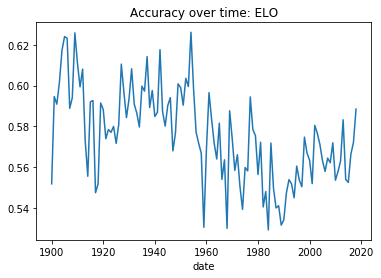

In [135]:
df.groupby(df.date.dt.year)['prediction_correct'].mean().plot()
plt.title("Accuracy over time: ELO");

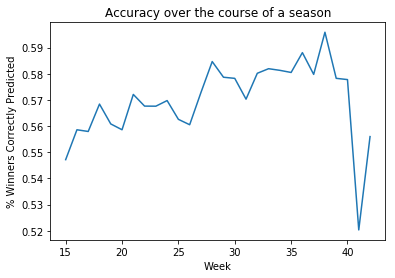

In [136]:
subset = df[(df.date.dt.week > 14) & (df.date.dt.week < 43)]
subset.groupby(df.date.dt.week)['prediction_correct'].mean().plot()
plt.title("Accuracy over the course of a season");
plt.xlabel('Week');
plt.ylabel('% Winners Correctly Predicted');

In [137]:
teams_by_gms = df.groupby('team1')['date'].count().sort_values(ascending=False)
teams_by_gms

team1
STL    9454
LAD    9417
CHC    9411
NYY    9391
SFG    9386
CIN    9378
PIT    9362
ATL    9321
BOS    9314
DET    9298
PHI    9297
MIN    9297
CLE    9289
BAL    9257
OAK    9255
CHW    9247
ANA    4680
TEX    4658
HOU    4599
NYM    4596
KCR    4014
SDP    4006
MIL    4003
WSN    3977
TOR    3375
SEA    3355
FLA    2087
COL    2084
ARI    1722
TBD    1714
Name: date, dtype: int64

In [139]:
df.groupby('predicted_winner')['prediction_correct'].mean().sort_values(ascending=False)

predicted_winner
NYY    0.610718
OAK    0.592067
SFG    0.584881
BOS    0.580534
LAD    0.579141
PIT    0.579087
STL    0.577927
CLE    0.576049
CHC    0.571215
CIN    0.570394
DET    0.569166
ATL    0.567832
BAL    0.567540
PHI    0.566219
HOU    0.565645
MIN    0.565178
ARI    0.564086
CHW    0.560478
NYM    0.559682
WSN    0.559027
TOR    0.556760
ANA    0.555088
TBD    0.552652
COL    0.548267
TEX    0.546279
SEA    0.545888
KCR    0.544005
FLA    0.540736
MIL    0.538531
SDP    0.531758
Name: prediction_correct, dtype: float64